# Estruturas Criptográficas - Criptografia e Segurança da Informação

[Grupo 03](https://paper.dropbox.com/doc/Estruturas-Criptograficas-2023-2024-Trabalhos-Praticos-8WcsdZARGLv0nXS9KasmK)

(PG54177) Ricardo Alves Oliveira 

(PG54236) Simão Oliveira Alvim Barroso

## TP4 - Exercício 3

Construir tabelas de comparações das suas implementações, para os vários níveis de segurança  NIST e em termos dos seguintes parâmetros:

1. Tempos: geração das chaves, produção da assinatura e verificação da assinatura.
2. Tamanhos: da chave pública, da chave privada e da assinatura.

#### Librarias Utilizadas

Esta secção é dedicada ao import das librarias necessárias para a realização do exercício.

In [38]:
from sage.all import *
import hashlib
import time
import matplotlib.pyplot as plt
import numpy as np

### Implementação Dilithium

Implementação do esquema de assinaturas Dilithium em Pythob+Sagemath como descrita no exercicio 1.

In [16]:
def bits_to_integer(y):
    alpha = len(y)
    x = 0
    for i in range(1, alpha + 1):
        x = y[alpha - i] + 2 * x
    return x

def bits_to_bytes(y):
    c = len(y)
    num_bytes = ceil(c / 8)
    z = [0] * num_bytes
    for i in range(c):
        z[i // 8] = z[i // 8] + y[i] * 2**(i % 8)
    return z

def bit_reverse(x, bits):
    y = 0
    for i in range(bits):
        y = (y << 1) | (x & 1)
        x >>= 1
    return y

def bytes_to_bits(z):
    d = len(z)
    y = [0] * (d * 8)
    for i in range(d):
        for j in range(8):
            y[8*i + j] = z[i] % 2
            z[i] = z[i] // 2
    return y

def bitlen(x):
    return x.nbits()

def simple_bit_pack(w, b):
    z = []
    for i in range(256):
        z = z+integer_to_bits(w[i], bitlen(b))
    return bits_to_bytes(z)

def simple_bit_unpack(v, b):
    c = bitlen(b)
    z = bytes_to_bits(v)
    w = [0] * 256
    for i in range(256):
        # BitsToInteger((z[ic], z[ic + 1], . . . z[ic + c − 1]), c)
        w[i] = bits_to_integer(z[i*c:(i+1)*c])
    return w

def bit_pack(w, a, b):
    z = []
    for i in range(256):
        z = z+integer_to_bits(b - w[i], bitlen(a + b))
    return bits_to_bytes(z)

def bit_unpack(v, a, b):
    c = bitlen(a+b)
    z = bytes_to_bits(v)
    w = []
    for i in range(256):
        wi = b - bits_to_integer(z[i*c:(i+1)*c])
        w.append(wi)
    return w

def H1024(input_bytes):
    hash_output = hashlib.sha256(input_bytes).digest()
    concatenated_output = hash_output
    while len(concatenated_output) < 128:  
        hash_output = hashlib.sha256(hash_output).digest()
        concatenated_output += hash_output
    concatenated_output = concatenated_output[:128]  

    bit_array = []
    for byte in concatenated_output:
        bits = bin(byte)[2:].zfill(8) 
        bit_array.extend(int(bit) for bit in bits)

    return bit_array

def integer_to_bits(x, alpha):
    y = [0] * alpha
    for i in range(alpha):
        y[i] = Integer(x) % Integer(2)
        x = x // 2
    return y

def coef_from_three_bytes(b0, b1, b2, q):
    if b2 > 127:
        b2 -= 128 
    z = 2 ** 16 * b2 + 2 ** 8 * b1 + b0
    if z < q:
        return z
    else:
        return None

def coef_from_half_byte(b, n):
    if n == 2 and b < 15:
        return 2 - (b % 5)
    elif n == 4 and b < 9:
        return 4 - b
    else:
        return None
    
def rej_ntt_poly(seed, q):
    a_hat = [None] * 256
    j = 0
    c = 0
    hsh=bits_to_bytes(H1024(bytearray(seed)))
    while j < 256:
        a_hat[j] = coef_from_three_bytes(hsh[c%128],hsh[(c+1)%128],hsh[(c+2)%128],q)
        c += 3
        if a_hat[j] is not None:
            j += 1
    return a_hat

def rej_bounded_poly(seed, q, n):
    a = [0] * 256
    j = 0
    c = 0
    hsh=bits_to_bytes(H1024(bytearray(seed)))
    while j < 256:
        z = hsh[c%128]
        z0 = coef_from_half_byte(z % 16, n)
        z1 = coef_from_half_byte(z // 16, n)
        if z0 is not None:
            a[j] = z0
            j += 1
        if z1 is not None and j < 256:
            a[j] = z1
            j += 1
        c += 1
    return a

def expand_a(p, q, k, l):
    A_hat = [[None for _ in range(l)] for _ in range(k)] 
    for r in range(k):
        for s in range(l):
            bits_s = integer_to_bits(s, 8)
            bits_r = integer_to_bits(r, 8)
            combined_bytes = bytearray(p) + bytearray(bits_s) + bytearray(bits_r)
            A_hat[r][s] = rej_ntt_poly(combined_bytes, q)[s]
    return A_hat

def expand_s(p, l, k,q,n):
    s1 = [rej_bounded_poly(p + integer_to_bits(r, 16),q,n) for r in range(l)]
    s2 = [rej_bounded_poly(p + integer_to_bits(r + l, 16),q,n) for r in range(k)]
    return (s1, s2)

def polynomial_mul(a, b, q):
    return [(a[i] * b[i]) % q for i in range(len(a))]

def ntt(w, q):
    w_hat = [0 for _ in range(256)]
    for j in range(256):
        w_hat[j] = w[j]
    z=1753
    k = 0
    length = 128
    while length >= 1:
        start = 0
        while start < 256:
            k += 1
            zeta = Integer(z**bit_reverse(k, 8)) % Integer(q)
            for j in range(start, start + length):
                t = zeta * w_hat[j + length]
                w_hat[j + length] = (w_hat[j] - t) 
                w_hat[j] = (w_hat[j] + t) % q
            start += 2 * length
        length = length // 2
    return w_hat

def ntt_inverse(w_hat, q):
    w = [0 for _ in range(256)]
    for j in range(256):
        w[j] = w_hat[j]
    z=1753
    k = 256
    length = 1
    while length < 256:
        start = 0
        while start < 256:
            k -= 1
            zeta = (-1 * Integer(z**bit_reverse(k, 8))) % Integer(q)
            for j in range(start, start + length):
                t = w[j]
                w[j] = (t + w[j + length]) 
                w[j + length] = (t - w[j + length]) 
                w[j + length] = zeta * w[j + length] 
            start += 2 * length
        length *= 2
    f = 8347681
    for j in range(256):
        w[j] = f * w[j] % q
    return w

def mod_plus_minus(m, alpha):
    m_prime = Integer(m) % Integer(alpha)
    if m_prime > alpha // 2:
        m_prime -= alpha
    return m_prime

def power2_round(r, q, d):
    r_plus = Integer(r) % Integer(q)
    r0 = mod_plus_minus(r_plus,2**d)
    r1 = (r_plus - r0) // (2**d)
    return (r1, r0)

def pk_encode(p, t1, q, d, k):
    pk = bits_to_bytes(p)
    max_value = (2 ** (bitlen(q - 1) - d)) - 1
    for i in range(k):
        pk += simple_bit_pack(t1[i], max_value)
    return pk

def pk_decode(pk, q, d, k):
    y = pk[:32]
    len_z = 32*(bitlen(q - 1)-d)
    z=[]
    for i in range(k):
        z.append(pk[32+i*len_z:32+(i+1)*len_z])
    p = bytes_to_bits(y)
    max_value = (2 ** (bitlen(q - 1) - d)) - 1
    t = [None for _ in range(k)]
    for i in range(k):
        t[i] = simple_bit_unpack(z[i], max_value)
    return p, t

def sk_encode(p, K, tr, s1, s2, t0, d, n): 
    sk = bits_to_bytes(p) + bits_to_bytes(K) + bits_to_bytes(tr)
    for si in s1:
        sk = sk + bit_pack(si, n, n)
    for si in s2:
        sk = sk + bit_pack(si, n, n)
    for ti in t0:
        sk = sk + bit_pack(ti, (2**(d-1))-1, 2**(d-1))
    return sk

def sk_decode(sk, d, n, l, k):
    f = sk[:32]
    g = sk[32:64]
    h = sk[64:128]
    a_len = 32 * bitlen(2*n)
    y=[]
    for i in range(l):
        y.append(sk[128+i*a_len:128+(i+1)*a_len])
    z=[]
    for i in range(k):
        z.append(sk[128+l*a_len+i*a_len:128+l*a_len+(i+1)*a_len])
    w_len = 32*d
    w=[]
    for i in range(k):
        w.append(sk[128+(l+k)*a_len+i*w_len:128+(l+k)*a_len+(i+1)*w_len])
    p = bytes_to_bits(f)
    K = bytes_to_bits(g)
    tr = bytes_to_bits(h)
    s1 = [bit_unpack(yi, n, n) for yi in y]
    s2 = [bit_unpack(zi, n, n) for zi in z]
    t0 = [bit_unpack(wi, (2**(d-1))-1, 2**(d-1)) for wi in w]
    return p, K, tr, s1, s2, t0

def matrix_mutl(m_a,m_b,q):
    m_c = [[0 for _ in range(len(m_b[0]))] for _ in range(len(m_a))]
    for i in range(len(m_a)):
        for j in range(len(m_b[0])):
            for k in range(len(m_b)):
                m_c[i][j] += m_a[i][k] * m_b[k][j]
                m_c[i][j] %= q
    return m_c

def decompose(r,q,y2):
    r_plus = Integer(r) % Integer(q)
    r0 = mod_plus_minus(r_plus,(2*y2))
    if r_plus - r0 == q - 1:
        r1 = 0
        r0 = r0 - 1
    else:
        r1 = (r_plus - r0) // (2*y2)
    return (r1, r0)

def high_bits(r,q,y2):
    (r1,r0) = decompose(r, q, y2)
    return r1

def low_bits(r,q,y2):
    (r1,r0) = decompose(r, q, y2)
    return r0

def expand_mask(seed, mu, l, gamma_1):
    c = 1 + bitlen(gamma_1-1)
    s = [None for _ in range(l)]
    for r in range(l):
        n = integer_to_bits(mu+r, 16)
        v = [ None for _ in range(32*c)]
        byts = bits_to_bytes(H1024(bytearray(seed+n)))
        for i in range(32*c):
            v[i] = byts[(32*r*c + i)%128]
        s[r] = bit_unpack(v, gamma_1 - 1, gamma_1)
    return s

def w1_encode(w1, k, q, y2):
    w1_tilde = []
    for i in range(k):
        w1_tilde = w1_tilde + bytes_to_bits(simple_bit_pack(w1[i], Integer(((q - 1) / (2 * y2)) - 1)))
    return w1_tilde

def sample_in_ball(seed, tau):
    c = [0 for _ in range(256)]
    k = 8
    for i in range(256 - tau, 256):
        while bits_to_bytes(H1024(bytearray(seed)))[k%128] > i:
            k += 1
        j = bits_to_bytes(H1024(bytearray(seed)))[k%128]
        c[i] = c[j]
        c[j] = (-1) ** (H1024(bytearray(seed))[i+tau-256])
        k += 1
    return c

def make_hint(z, r, q, y2):
    r1 = high_bits(r,q,y2)
    v1 = high_bits(r + z,q,y2)
    if r1 != v1:
        return 1
    return 0

def use_hint(h, r, q, gamma_2):
    m = (q - 1) // (2 * gamma_2)
    r1,r0 = decompose(r, q, gamma_2)
    if h==1 and r0 > 0:
        return (r1 + 1) % m
    elif h==1 and r0 <= 0:
        return (r1 - 1) % m
    else:
        return r1

def hint_bit_pack(h,omega,k):
    y = [0] * (omega + k)
    index = 0
    for i in range(k):
        for j in range(256):
            if h[i][j] != 0: 
                y[index] = j
                index += 1
        y[omega + i] = index
    return y

def sig_encode(c_til, z, h, l, y1, omega, k):
    o = bits_to_bytes(c_til)
    for i in range(l):
        o = o + bit_pack(z[i], y1 - 1, y1)
    o = o + hint_bit_pack(h,omega,k)
    return o


def hint_bit_unpack(y, k, omega):
    h = [[0]*256 for _ in range(k)]  
    index = 0
    for i in range(k):
        if y[omega + i] < index or y[omega + i] > omega:
            return None
        while index < y[omega + i]:
            h[i][y[index]] = 1
            index += 1
    while index < omega:
        if y[index] != 0:
            return None
        index += 1
    return h

def sig_decode(o, y1, lbd, l, k, omega):
    lbd = lbd // 4
    w = o[:lbd]
    x = []
    for i in range(l):
        x.append(o[lbd + 32*(1+bitlen(y1-1))*i:lbd + 32*(1+bitlen(y1-1))*(i+1)])
    y = o[lbd + l*32*(1+bitlen(y1-1)):]
    c_til = bytes_to_bits(w)
    z = [None for _ in range(l)]
    for i in range(l):
        z[i] = bit_unpack(x[i], y1 - 1, y1)
    h = hint_bit_unpack(y,k,omega)
    return c_til, z, h

def ML_DSA_KeyGen(k, l, q, d, n):
    eps = [randint(0, 1) for _ in range(256)]
    H_output = H1024(bytearray(eps))
    p = H_output[:256]
    p_ = H_output[256:768]
    K = H_output[768:]
    A_hat = expand_a(p, q, k, l)
    s1, s2 = expand_s(p_, l, k,q,n)
    NTT_s1 = []
    for i in range(l):
        s1_poly = PolynomialRing(Zmod(q), 'x')(s1[i])
        NTT_s1.append(ntt(s1_poly, q))
    A_NTT_s1 = matrix_mutl(A_hat, NTT_s1, q)
    t = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(A_NTT_s1_row), q) for A_NTT_s1_row in A_NTT_s1]
    for i in range(k):
        for j in range(256):
            t[i][j] = (t[i][j] + s2[i][j])
    t1, t0 = [], []
    for tt in t:
        tt1, tt0 = [], []
        for ti in tt:
            t1i, t0i = power2_round(ti, q, d)
            tt1.append(t1i)
            tt0.append(t0i)
        t1.append(tt1)
        t0.append(tt0)
    pk = pk_encode(p, t1, q, d,k)
    tr = H1024(bytearray(pk))[:512]
    sk = sk_encode(p, K, tr, s1, s2, t0, d, n)
    return pk, sk

def ML_DSA_Sign(sk, M, Tq, q, d, n, l, k, tau, gamma_1, gamma_2, omega, beta):
    rho, K, tr, s1, s2, t0 = sk_decode(sk, d, n, l, k)
    mu = H1024(bytearray(tr+M))[:512]
    s1_hat = [ntt(poly, q) for poly in s1]
    s2_hat = [ntt(poly, q) for poly in s2]
    t0_hat = [ntt(poly, q) for poly in t0]    
    A_hat = expand_a(rho, q, k, l)
    rnd = [randint(0, 1) for _ in range(256)]
    rho_prime = H1024(bytearray(K + rnd + mu))[:512]
    kappa = 0
    z, zz, h = None, None, None
    while z is None or h is None:
        y = expand_mask(rho_prime, kappa, l, gamma_1)
        NTT_y =[]
        for i in range(l):
            y_poly = PolynomialRing(Zmod(q), 'x')(y[i])
            NTT_y.append(ntt(y_poly, q))
        A_NTT = matrix_mutl(A_hat, NTT_y, q)
        w = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(A_NTT_row), q) for A_NTT_row in A_NTT]
        w1 = [[high_bits(n,q,gamma_2) for n in poly] for poly in w]
        c_til = H1024(bytearray(mu + w1_encode(w1, k, q, gamma_2)))[:(2*Tq)]
        c_til_1, c_til_2 = c_til[:256], c_til[256:]
        c = sample_in_ball(c_til_1, tau)
        c_poly = PolynomialRing(Zmod(q), 'x')(c)
        c_hat = ntt(c_poly, q)
        cs1_hat = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(polynomial_mul(c_hat,s_hat,q)), q) for s_hat in s1_hat]
        cs2_hat = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(polynomial_mul(c_hat,s_hat,q)), q) for s_hat in s2_hat]
        z=[[Integer(y[i][j])+Integer(cs1_hat[i][j]) for j in range(len(cs1_hat[i]))] for i in range(len(cs1_hat))]
        r0 = [[low_bits(Integer(w[i][j]) - Integer(cs2_hat[i][j]), q, gamma_2) for j in range(len(cs2_hat[i]))] for i in range(len(cs2_hat))]
        zz = [[mod_plus_minus(ze,q) for ze in zl] for zl in z]
        if max(map(max, zz)) >= gamma_1 - beta or max(map(max, r0)) >= gamma_2 - beta:
            z, h = None, None
        else:
            ct0_hat = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(polynomial_mul(c_hat,t_hat,q)), q) for t_hat in t0_hat]
            h = [[make_hint((Integer(-1) * Integer(ct0_hat[x][y])),(Integer(w[x][y])-Integer(cs2_hat[x][y])+Integer(ct0_hat[x][y])),q,gamma_2) for y in range(len(w[x]))] for x in range(len(w))]
            ct0_pm = [[mod_plus_minus(y,q) for y in x] for x in ct0_hat]
            if max(map(max, ct0_pm)) >= gamma_2 or sum(map(sum, h)) > omega:
                z, h = None, None
        kappa += l
    sigma = sig_encode(c_til, zz, h, l, gamma_1, omega, k)
    ctilt,zt,ht = sig_decode(sigma, gamma_1, Tq, l, k, omega)
    return sigma

def ML_DSA_Verify(pk, M, sigma, q, tau, gamma_1, gamma_2, omega, beta, Tq, k, l, d):
    rho, t1 = pk_decode(pk, q, d, k)
    c_til, z, h = sig_decode(sigma, gamma_1, Tq, l, k, omega)
    ctil_, _ = c_til[:256], c_til[256:]
    if h is None:
        return False
    A_hat = expand_a(rho, q, k, l)
    tr = H1024(bytearray(pk))[:512]
    mu = H1024(bytearray(tr + M))[:512]
    c = sample_in_ball(ctil_, tau)
    ntt_z = [ntt(PolynomialRing(Zmod(q), 'x')(poly), q) for poly in z]
    A_NTT = matrix_mutl(A_hat, ntt_z, q)
    ntt_c = ntt(PolynomialRing(Zmod(q), 'x')(c), q)
    ntt_t1= [ntt(PolynomialRing(Zmod(q), 'x')([x*(2**d) for x in poly]), q) for poly in t1]
    t1_c = [polynomial_mul(ntt_t1[i], ntt_c, q) for i in range(len(t1))]
    fntt=[[(Integer(A_NTT[i][j])-Integer(t1_c[i][j])) % q for j in range(len(A_NTT[i]))] for i in range(len(A_NTT))]
    waprox = [ntt_inverse(PolynomialRing(Zmod(q), 'x')(poly), q) for poly in fntt]
    w_prime = [[use_hint(Integer(h[i][j]) % q,Integer(waprox[i][j]),q,gamma_2) for j in range(len(waprox[i]))] for i in range(len(waprox))]
    c_til_ = H1024(bytearray(mu + w1_encode(w_prime, k, q, gamma_2)))[:(2*Tq)]
    zz = [[mod_plus_minus(ze,q) for ze in zl] for zl in z]
    return c_til==c_til_ and max(map(max, zz)) < gamma_1 - beta and sum(map(sum, h)) <= omega


### Testes ao Dilithium

#### Função de teste

In [17]:
def Dilitium_Test(version, message):
    q = 8380417
    d = 13
    tau=39
    lbd = 128
    gamma_1 = 2**17
    gamma_2 = (q - 1) // 88
    k = 4
    l = 4
    n = 2
    beta = 78
    omega = 80
    if version == 65:
        tau=49
        lbd = 192
        gamma_1 = 2**19
        gamma_2 = (q - 1) // 32
        k = 6
        l = 5
        n = 4
        beta = 196
        omega = 55   
    elif version == 87:
        tau=60
        lbd = 256
        gamma_1 = 2**19
        gamma_2 = (q - 1) // 32
        k = 8
        l = 7
        n = 2
        beta = 120
        omega = 75 

    time_start = time.time()
    pk, sk = ML_DSA_KeyGen(k, l, q, d, n)
    time_kg = time.time() - time_start

    M_bytes = bytearray(message.encode())
    M_bits = bytes_to_bits(M_bytes)

    time_start = time.time()
    sign = ML_DSA_Sign(sk, M_bits, lbd, q, d, n, l, k, tau, gamma_1, gamma_2, omega, beta)
    time_sign = time.time() - time_start

    time_start = time.time()
    is_valid = ML_DSA_Verify(pk, M_bits, sign, q, tau, gamma_1, gamma_2, omega, beta, lbd, k, l, d)
    time_verify = time.time() - time_start

    return [time_kg, time_sign, time_verify, is_valid, pk, sk, sign]

#### Teste Manual

Teste manual ao esquema de assinaturas Dilithium


In [18]:

message = input("Enter the message: ")
version = 1
while version not in [44, 65, 87]:
    version = int(input("Enter the version 44/65/87: "))
tkg,ts,tv,ver,pk,sk,sign=Dilitium_Test(version, message)

print("Key Generation Time: ", tkg)
print("Signing Time: ", ts)
print("Verification Time: ", tv)
print("Public Key: ", bytes(pk))
print("Public Key Size: ", len(pk))
print("Secret Key: ", bytes(sk))
print("Secret Key Size: ", len(sk))
print("Signature: ", bytes(sign))
print("Signature Size: ", len(sign))
if ver:
    print("Signature is valid.")
else:
    print("Signature is invalid.")

Key Generation Time:  0.847219705581665
Signing Time:  2.340895652770996
Verification Time:  1.6106774806976318
Public Key:  b'AU\xb7\x9d\xe0]\x9b7\xc6\x00u\x07\x91`R\x12@\x1c\xae/\xac\x13<=\x12GD\xa4\xb4\x1bS\xc3\x96\xa0`\x01\xc5\xad\xb2\xd9\x12\x9e\xe9A\x1cr\xdd\x7ftm,\xfd\xfb*\x00\xffe`2\xdfB\xd4\xbd]\xe1\xbcJ\xfeJ\x031\xd0M\x07q\x81"b\x9d\x821}\x08\xf1yZ\xf3D\x11E[\x0e\xf7\xae4\x15\x9d\x93W\x00G\x8a\x0b{\x97in\xf6\x86[y]\x12\x81@\xba\xdd!F\xe0\xca\xa6\x12~8\xb9tN)\xc7J\xcd\xc8\xca\x1f\x99]\x97{[#\x86\xd7\xb3\x1c\x83:\xb5\xabB\x81\xf2\xd8\xec\xa9\xbc\x12\xde&Z\x91J9\xb9\x8f\xe3LU\x05\xdb\xaaO3\xd1w\xbb\xb25\xbd\x07\xcb\xa5\x0b%:er\x7f\xd0\x07\xd9U-\xbe\x83K\xfa\xe15\xf8g\xb8w\x9aD_L\t\x82d\x16\xcbt0S\x81[\xd5\xbeC\x87\tu!V\xbf\x81\xde\x04\x94\x06:\xd4\xb2\xccN\xb6\nRTi\xaf-\xacx\xce;w\xf2I\x7f9\xedeZ\x13r\xb7V)}o+.\xe4\xec\x8a\xef\xa05\'N/\x9c\xf8\xa6\x85\xd9kS\x1d\xd8K\xd6NO\xa5jETm\r\x15P0\xd8i\xb8\xb1\x1a\xa2P\xf4*\xb1"\x86\xe3\x16`\xe3\xae\xd2il+\x00]\xd7H\xa9\xe9)_\xae\xa1\xbf\

#### Testes Automáticos

Testes automáticos aos diferentes niveis de segurança do Dilitium. Nestes são testados os tempos de geração de chaves, assinatura e verificação da assinatura, bem como os tamanhos da chave pública, privada e assinatura e se o algoritmo funciona corretamente.

In [19]:
times = {"44": [], "65": [], "87": []}

for i in range(10):
    message = "".join([chr(randint(65, 90)) for _ in range(10,1000)])
    print(message)
    for version in [44, 65, 87]:
        tkg,ts,tv,ver,pk,sk,sign=Dilitium_Test(version, message)
        print(version,tkg,ts,tv,ver,len(sk),len(pk),len(sign))
        if not(ver):
            print("Invalid Signature")
            break
        times[str(version)].append([tkg, ts, tv, len(pk), len(sk), len(sign), len(message)])

# Times and lens from Dilitium 44 Tests
dil_dsa44_kg_times = [x[0] for x in times["44"]]
dil_dsa44_sign_times = [x[1] for x in times["44"]]
dil_dsa44_verify_times = [x[2] for x in times["44"]]
dil_dsa44_pk_len = times["44"][0][3]
dil_dsa44_sk_len = times["44"][0][4]
dil_dsa44_sign_len = times["44"][0][5]
dil_dsa44_message_lens = [x[6] for x in times["44"]]


# Times and lens from Dilitium 65 Tests
dil_dsa65_kg_times = [x[0] for x in times["65"]]
dil_dsa65_sign_times = [x[1] for x in times["65"]]
dil_dsa65_verify_times = [x[2] for x in times["65"]]
dil_dsa65_pk_len = times["65"][0][3]
dil_dsa65_sk_len = times["65"][0][4]
dil_dsa65_sign_len = times["65"][0][5]
dil_dsa65_message_lens = [x[6] for x in times["65"]]

# Times and lens from Dilitium 87 Tests
dil_dsa87_kg_times = [x[0] for x in times["87"]]
dil_dsa87_sign_times = [x[1] for x in times["87"]]
dil_dsa87_verify_times = [x[2] for x in times["87"]]
dil_dsa87_pk_len = times["87"][0][3]
dil_dsa87_sk_len = times["87"][0][4]
dil_dsa87_sign_len = times["87"][0][5]
dil_dsa87_message_lens = [x[6] for x in times["87"]]


WLGOPYKDKYNDKKFGVVSPGOYEKATZBKCGDUASUOJOUCWGCMQYEWSLWDYZPETBTGWCYAVJMZSHKOJIKGYRTKSMWAOSSNWYLSDGZZRMUULKADJJYFFSMPUAKTZQBXIADMKGSCUOXOWYWYFJCEMXOCNXGFWIYDBHHFZAXUAXZCZQBSYYEBJJIMBRFONSPTILVMGTBNPPMYOTDHJCAAGLEFYFQKIVWQGWYYTWOORJAYGKYIBFUKNEFRFFSCUEMVGWCWONTOJUANLGDZGRAODKAPKLINLELJRTXGDXFCCSBDONPTVHHVEDCSCJTWPAOSDNMEPFOUQRCENCAHZDKGHTGUAVYSLTRNHERMVSBNCZKRJSNTMPQJVFLJEUEAPRWKJFPZQMGRILEWHWYWVGULTLMZICMEQAAEZFWICHMYVFRBMOEDTNNKFXOPBEOFFGVZPHANZDNPNXHOYCTDVLZURNRELZTBTNJDVSWGWDILPBPWHVXSUZOPFUUIWMQJEQNQKJXKEHVUXABQXYUYEDQIBZLLVRWAOVGSQNUAGVVXVMFVKOLZKNTTQDAGXPGOHQIKONGQARSBGGFLFKMHGDUUCAHTAJCHQOBVPVVVDHOJTLJTGYVVGJUHAXOCJPFZHANIIDHWWLVUVPNPEDXYNCQJQRIYIZBOGJAFTDSUMXRIKWQZXIOLBUQWBMFXXSDBZMBNOUCJCSCIYWPJLJWUZYACBVYMEPRFKHMZARZMDSKNTQRJFWQMEUUEBUFTBFKANLILBOUCYGVARQMLUSWIITZQNVYCAPUKGGEXGBRECLKKFAKCLNDZFCRHSASGHJSLNPCQSCNPYHAHQIWPRLPZWNKTUPTQFJIQBUQQRHRFSEMDCWTNUTFHZNFAZDHKAVZINALMOPCPHZRRMDPVTCVQIWPTCNERUUAMZDPVJLNYKPOMTFXBGUCHLGILSTWGGLBKEZMDLVOTVFAQMBQDXSIIAVPGLMVGPZOUUSIIXUVJ
44 0.8666

#### Análise aos resultados

##### Tamanhos da chave Pública, Privada e Assinatura

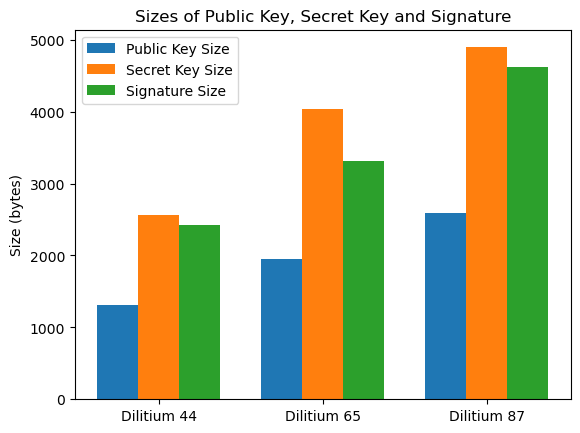

In [27]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']
pk_lens = [dil_dsa44_pk_len, dil_dsa65_pk_len, dil_dsa87_pk_len]
sk_lens = [dil_dsa44_sk_len, dil_dsa65_sk_len, dil_dsa87_sk_len]
sign_lens = [dil_dsa44_sign_len, dil_dsa65_sign_len, dil_dsa87_sign_len]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, pk_lens, width, label='Public Key Size')
rects2 = ax.bar(x, sk_lens, width, label='Secret Key Size')
rects3 = ax.bar(x + width, sign_lens, width, label='Signature Size')

ax.set_ylabel('Size (bytes)')
ax.set_title('Sizes of Public Key, Secret Key and Signature')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


##### Tempo médio de geração de chaves

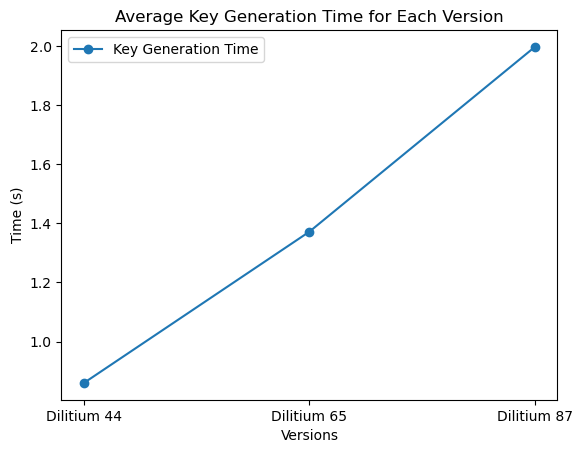

In [22]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']

kg_times = [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times)]
plt.plot(labels, kg_times, label='Key Generation Time', marker='o')
plt.xlabel('Versions')
plt.ylabel('Time (s)')
plt.title('Average Key Generation Time for Each Version')
plt.legend()
plt.show()


##### Tempo médio de assinatura de mensagens

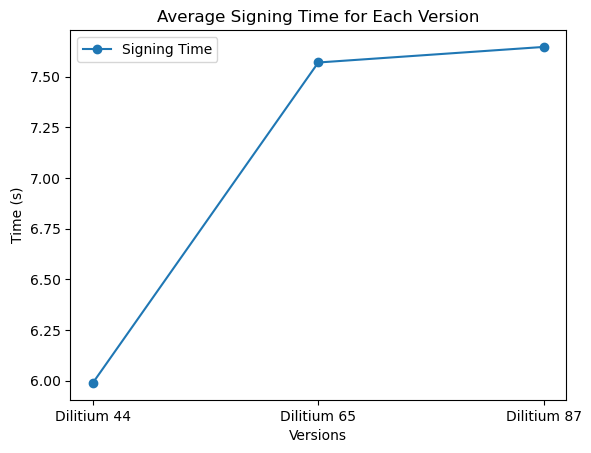

In [23]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']

sign_times = [sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times), sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times), sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times)]
plt.plot(labels, sign_times, label='Signing Time', marker='o')
plt.xlabel('Versions')
plt.ylabel('Time (s)')
plt.title('Average Signing Time for Each Version')
plt.legend()
plt.show()

##### Tempo médio de verificação de assinaturas

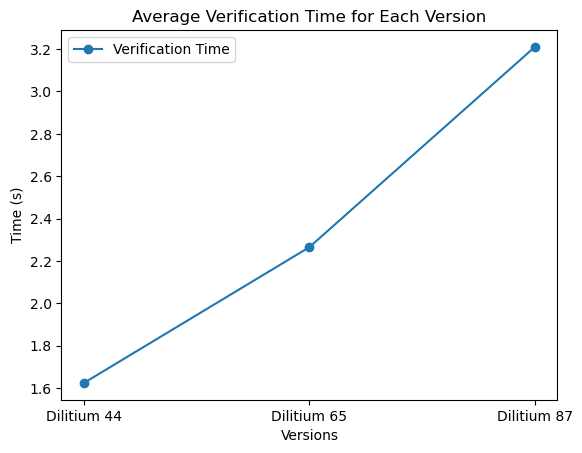

In [24]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']

verify_times = [sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)]
plt.plot(labels, verify_times, label='Verification Time', marker='o')
plt.xlabel('Versions')
plt.ylabel('Time (s)')
plt.title('Average Verification Time for Each Version')
plt.legend()
plt.show()

##### Tempo médio total

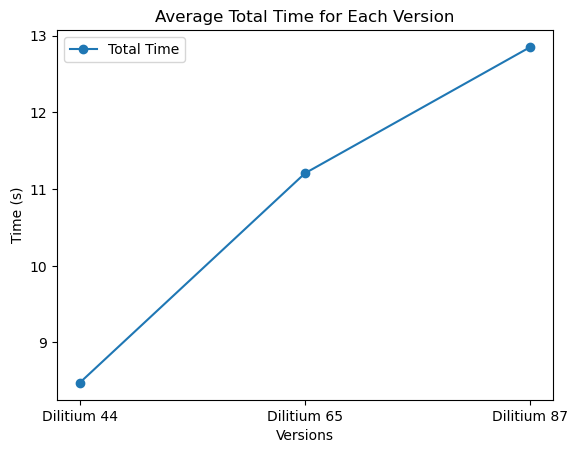

In [25]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']

total_times = [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times) + sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times) + sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times) + sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times) + sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times) + sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times) + sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)]
plt.plot(labels, total_times, label='Total Time', marker='o')
plt.xlabel('Versions')
plt.ylabel('Time (s)')
plt.title('Average Total Time for Each Version')
plt.legend()
plt.show()
 

##### Comparação dos tempos médios das várias componentes  

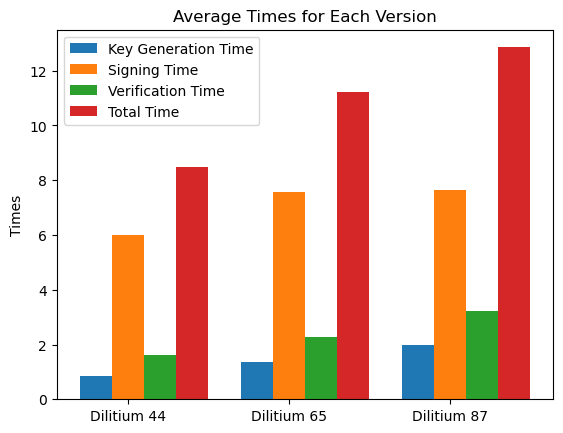

In [26]:
labels = ['Dilitium 44', 'Dilitium 65', 'Dilitium 87']

kg_times = [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times)]
sign_times = [sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times), sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times), sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times)]
verify_times = [sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)]
total_times = [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times) + sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times) + sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times) + sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times) + sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times) + sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times) + sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, kg_times, width, label='Key Generation Time')
rects2 = ax.bar(x, sign_times, width, label='Signing Time')
rects3 = ax.bar(x + width, verify_times, width, label='Verification Time')
rects4 = ax.bar(x + 2*width, total_times, width, label='Total Time')

ax.set_ylabel('Time(s)')
ax.set_title('Average Times for Each Version')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


### Tabela de Resultados

In [37]:
# Make a table with sizes and average times for each version

data = {'Version': ['Dilitium 44', 'Dilitium 65', 'Dilitium 87'], 
        'Public Key Size': [dil_dsa44_pk_len, dil_dsa65_pk_len, dil_dsa87_pk_len],
        'Secret Key Size': [dil_dsa44_sk_len, dil_dsa65_sk_len, dil_dsa87_sk_len],
        'Signature Size': [dil_dsa44_sign_len, dil_dsa65_sign_len, dil_dsa87_sign_len],
        'Average Key Generation Time': [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times)],
        'Average Signing Time': [sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times), sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times), sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times)],
        'Average Verification Time': [sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)],
        'Average Total Time': [sum(dil_dsa44_kg_times)/len(dil_dsa44_kg_times) + sum(dil_dsa44_sign_times)/len(dil_dsa44_sign_times) + sum(dil_dsa44_verify_times)/len(dil_dsa44_verify_times), sum(dil_dsa65_kg_times)/len(dil_dsa65_kg_times) + sum(dil_dsa65_sign_times)/len(dil_dsa65_sign_times) + sum(dil_dsa65_verify_times)/len(dil_dsa65_verify_times), sum(dil_dsa87_kg_times)/len(dil_dsa87_kg_times) + sum(dil_dsa87_sign_times)/len(dil_dsa87_sign_times) + sum(dil_dsa87_verify_times)/len(dil_dsa87_verify_times)]}

# dont use pandas
def format_cell(content):
    return f"{content:<30}"

# Print the header with separators
header = (
    format_cell("Version") + "|" +
    format_cell("Public Key Size") + "|" +
    format_cell("Secret Key Size") + "|" +
    format_cell("Signature Size") + "|" +
    format_cell("Average Key Generation Time") + "|" +
    format_cell("Average Signing Time") + "|" +
    format_cell("Average Verification Time") + "|" +
    format_cell("Average Total Time")
)
print(header)
print("-" * len(header))

# Print the data rows with separators
for i in range(3):
    row = (
        format_cell(data['Version'][i]) + "|" +
        format_cell(data['Public Key Size'][i]) + "|" +
        format_cell(data['Secret Key Size'][i]) + "|" +
        format_cell(data['Signature Size'][i]) + "|" +
        format_cell(data['Average Key Generation Time'][i]) + "|" +
        format_cell(data['Average Signing Time'][i]) + "|" +
        format_cell(data['Average Verification Time'][i]) + "|" +
        format_cell(data['Average Total Time'][i])
    )
    print(row)


Version                       |Public Key Size               |Secret Key Size               |Signature Size                |Average Key Generation Time   |Average Signing Time          |Average Verification Time     |Average Total Time            
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dilitium 44                   |1312                          |2560                          |2420                          |0.8601288318634033            |5.98874819278717              |1.6236273527145386            |8.472504377365112             
Dilitium 65                   |1952                          |4032                          |3309                          |1.372005295753479             |7.570431590080261             |2.26484215259552              |11.20727903842926             
Dilitium